Code for drawing graph animation

In [1]:
%matplotlib inline
from network_utilities import adjacency_matrix_to_graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple
from IPython import display

## Code for updating a Jupyter notebook plot in realtime
## is from google AI overview from prompt
## "jupyter notebook update plot in loop"

## All code assumes nodes are consecutive integers from 0 to some max number

desired_num_vertices: int = 30

def _get_initial_positions(desired_num_vertices: int) -> Tuple[nx.Graph, dict[int, tuple[float, float]]]:
    # Put all the vertices around a circle
    A: np.array = np.zeros((desired_num_vertices,desired_num_vertices))
    G = adjacency_matrix_to_graph(A)
    pos = nx.circular_layout(G)
    return G, pos

def _configure_plot(pos: dict[int, tuple[float,float]]) -> None:
    ax = plt.gca()
    x_positions: list[float] = [x for x,_ in pos.values()]
    y_positions: list[float] = [y for _,y in pos.values()]
    ax.set_xlim(min(x_positions)-.1, max(x_positions)+.1)
    ax.set_ylim(min(y_positions)-.1, max(y_positions)+.1)
    ax.set_aspect('equal')

def _update_plot(G: nx.Graph, 
                 pos: dict[int, tuple[float, float]], 
                 vertex_set: set[int], 
                 edge_set: set[tuple[int,int]]) -> None:
    desired_node_size = 200
    G.add_edges_from(edge_set)
    nx.draw_networkx_nodes(G, pos, 
                        nodelist = list(vertex_set),
                        node_color=['lightblue'],
                        node_size=desired_node_size,
                        alpha=0.8)
    nx.draw_networkx_edges(G,pos,edgelist=list(edge_set),width=0.5)

    display.clear_output(wait=True)
    display.display(plt.gcf())
    # Okay, I'm good...
    # I do not need to wait that long each time...
    time.sleep(0.05)


Functions for you to define

In [2]:
# Some helper functions I made
def get_degree(G: nx.Graph, node: int) -> int:
    return G.degree[node]

# Get sum of degree of all existing nodes
def get_total_degree(G: nx.Graph) -> int:
    total_degree: int = 0
    for node in G.nodes():
        total_degree += get_degree(G, node)
    return total_degree

In [3]:
def add_edges_wikipedia_version(vertex_set: set[int], 
               new_vertex: int, 
               G: nx.Graph) -> set[tuple[int,int]]:
    new_edges: set[tuple[int,int]] = set()
    total_degree: int = get_total_degree(G)
    # Sample all other edges, adding edges based on degree probability
    for existing_vertex in vertex_set:
        degree_existing_vertex: int = get_degree(G, existing_vertex)
        # I'm pretty sure this is the right way of doing it...
        # But I'm too lazy to double check the math right now...
        probability: float = degree_existing_vertex / total_degree
        random_value: float = np.random.rand()
        if random_value < probability:
            new_edges.add((new_vertex, existing_vertex))
    return new_edges


In [4]:
def add_edges_networkx_version(vertex_set: set[int], 
               new_vertex: int, 
               G: nx.Graph,
               required_edges: int = 1) -> set[tuple[int,int]]:
    new_edges: set[tuple[int,int]] = set()
    if required_edges < 1:
        raise ValueError("must have at least one required edge")
    while len(new_edges) < required_edges:
        # So this might add more edges than required, but that's okay... right?
        new_edges = add_edges_wikipedia_version(vertex_set, new_vertex, G)
    return new_edges


Wikipedia version

In [24]:
def run_simulation(add_edges_function, desired_num_vertices, vertex_set: set[int] = {0, 1}, edge_set: set[tuple[int,int]] = {(0,1)}) -> None:
    # Initialize drawing
    G, pos = _get_initial_positions(desired_num_vertices)
    _configure_plot(pos)

    # Add edges
    while len(vertex_set) <= desired_num_vertices:
        _update_plot(G, pos, vertex_set, edge_set)
        new_vertex = len(vertex_set)
        new_edges = add_edges_function(vertex_set, new_vertex, G)
        vertex_set.add(new_vertex)
        edge_set.update(new_edges)
    return G

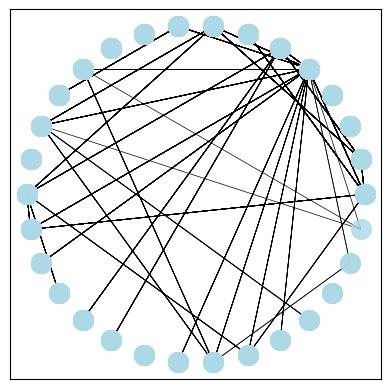

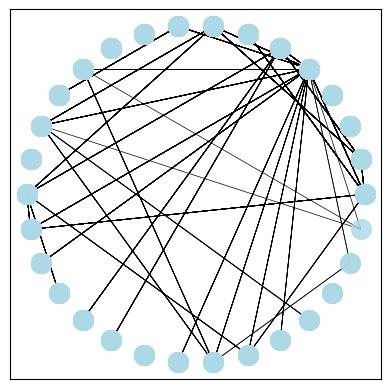

In [25]:
run_simulation(add_edges_wikipedia_version, desired_num_vertices)

> Huh, okay, that looks like it actually worked, neat...

Networkx version

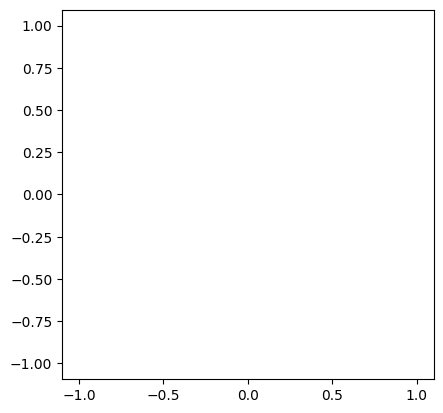

In [26]:
run_simulation(add_edges_networkx_version, desired_num_vertices)

> Okay, that looks right too... Neat...

## Tasks

1. Run the algorithm for various initial numbers of connected vertices (the m0) on the wikipedia page.


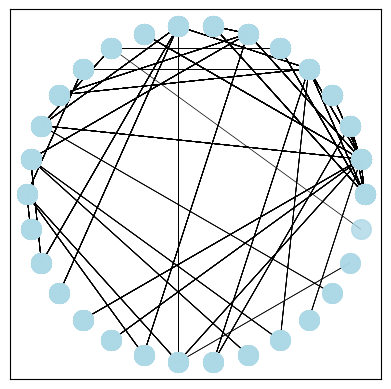

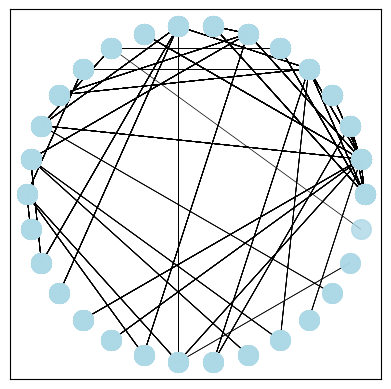

In [27]:
run_simulation(add_edges_networkx_version, desired_num_vertices, vertex_set={0,1,2}, edge_set={(0,1), (1,2), (2,0)})

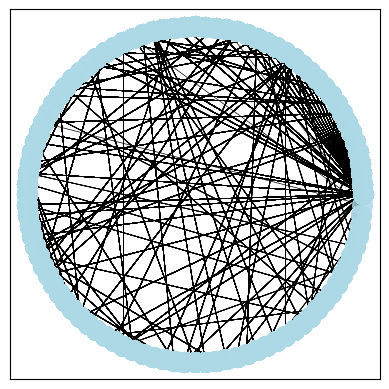

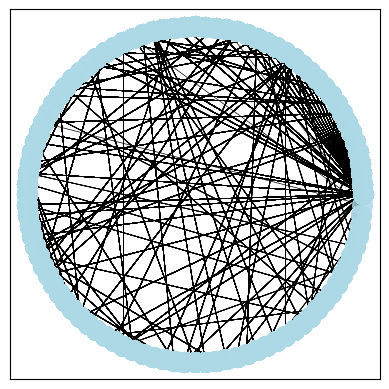

In [35]:
# Let's do a star shaped graph with lots of starting nodes
interesting_result = run_simulation(add_edges_networkx_version, 100,
                                    vertex_set={0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20},
                                    edge_set={(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,10), (0, 11), (0,12), (0,13), (0,14), (0,15), (0,16), (0,17), (0,18), (0,19), (0,20)
    })

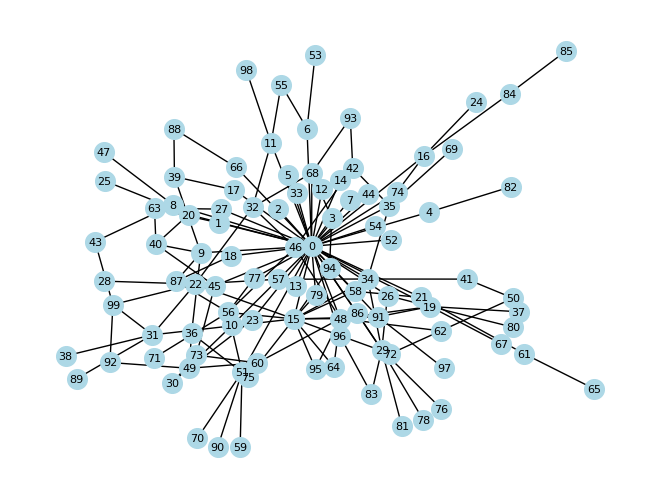

In [36]:
# Let's display the resulting graph using the spring layout
plt.figure()
pos = nx.spring_layout(interesting_result)
nx.draw(interesting_result, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=8)
plt.show()

> Yeah, that 0 node is def the most popular, but it does look like there are some nodes who are more "important"... Let's see if that holds in the degree distribution.


2. Choose some of the interesting results and plot the histogram of the degree distribution. Use the "log-log" plot technique discussed in class, and discuss whether the network is scale free. You might find some of the visualization code from this file useful. It's code I used to 3.create some of the figures in the class slides, and it utilizes some of the functions in the network_utilities.py file.

> I like the results of that star one, everyone wants to be with Mr. Popular.
> Let's see what that looks like in a log-log plot.


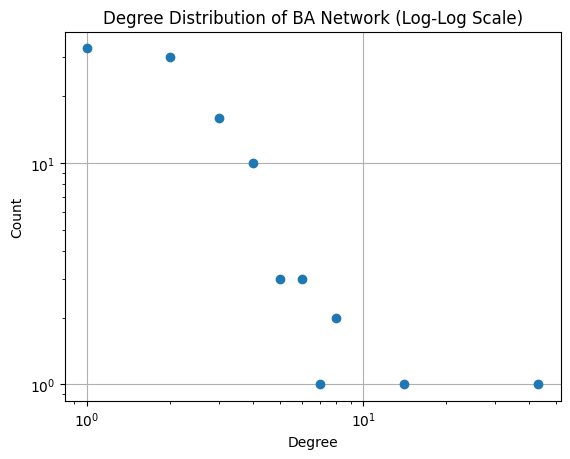

In [37]:
# Log Log Plot of Degree Distribution
degree_count: dict[int,int] = {}
for node in interesting_result.nodes():
    degree = interesting_result.degree[node]
    if degree not in degree_count:
        degree_count[degree] = 0
    degree_count[degree] += 1
degrees: list[int] = list(degree_count.keys())
counts: list[int] = [degree_count[degree] for degree in degrees]

plt.figure()
plt.loglog(degrees, counts, marker='o', linestyle='None')
plt.title("Degree Distribution of BA Network (Log-Log Scale)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [38]:
degree_count

{43: 1, 2: 30, 1: 33, 3: 16, 5: 3, 4: 10, 14: 1, 7: 1, 6: 3, 8: 2}

3. Describe what you observed from the animations and relate it to the phrase "the rich get richer". Discuss what this means for why some networks evolve to display the scale-free property.

> In the "interesting result" graph, we can see that our "richest" node is richer than the rest by far. Even though we create 100 nodes, and that node only started with 10 neighbors, it ends up getting to a degree of 43, while the second highest is just 14.

> In the log-log graph we can see that it does resemble that power-law (up until the tail, which as we discussed in class is an expected behavior of models or behaviors like this).

> In short, the idea behind the rich get richer, is that the nodes that "have more" tend to "get more", and thereby they "have more", so they tend to get *even more*. This continues forever, and this is why we see that power scale appear in such scenarios. In these scenarios a simple exponential growth doesn't grow fast enough to accurately model behaviors that have the scale-free property.

> Some networks can develop this by having a rule which leads to more growth giving more growth. When you have more money you can get more money more easily. When you have a lot of diseases your immune system is weaker and you can get even more. If you have a lot of friends its easier to make friends. If your website has a lot of links to it, more people will see it, and more people will begin to link to it. These are all examples of graph-like structures that tend towards exhibiting scale-free properties.

> As for 'scale free', as discussed in class we call it that because in the log-log view, the coefficient only shifts the graph, not change the slope.